# Nice to Meat You : An Analysis on Meat Consumption

## Introduction

Meat consumption is a highly controversial topic in nowadays society in terms of [environment](https://www.theguardian.com/environment/2018/oct/10/huge-reduction-in-meat-eating-essential-to-avoid-climate-breakdown), [health](https://gamechangersmovie.com/), and [ethical](http://traslosmuros.com/en/slaughterhouse-documentary/) reasons. This situation introduces different ways of consuming meat and divides people according to their behaviors such as vegan, vegetarian, occasional meat consumer, and people consuming large amounts of meats.

In this project, we are particularly interested in the factors related to consuming meat and how the behavior of households varies according to their meat consumption. We are going to focus on demographic information such as economic status, family composition, age, and their relation with consuming meat. Moreover, we are going to study external effects that are related to meat consumption such as seasonal changes, campaigns, and discounts. Finally, we are going to categorize households according to their meat consumption and perform a behavior analysis per category.

To do so, we are going to use the Dunnhumby dataset. This dataset contains shopping information collected over two years from a group of 2,500 households as well as their information for each household. Moreover, we are planning to expand our analysis with an additional dataset about nutritional information.


## Factors that influence meat consumption

### Loading the data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup

In [2]:
products = pd.read_csv('dunnhumby/product.csv', sep = ',')

### Characterising the products

The first step of the project is to correctly collect the products for each category in which we want to do further analysis. The objective is to be able to select food products, meat products and vegetables. 

In [3]:
print('There are {0} rows and {1} columns in the dataset.'.format(len(products), len(products.columns))) 
print('Number of columns with missing values is {0}.'.format(len(products.columns.to_numpy()[products.isna().any()])))
print('Columns:')
print('--------')
for col in products.columns:
    print(col)

There are 92353 rows and 7 columns in the dataset.
Number of columns with missing values is 0.
Columns:
--------
PRODUCT_ID
MANUFACTURER
DEPARTMENT
BRAND
COMMODITY_DESC
SUB_COMMODITY_DESC
CURR_SIZE_OF_PRODUCT


There are 7 columns and three of them allow us to have information about the type of the product. The broadest one is 'DEPARTMENT'. Each one of these contains one or more 'COMMODITY_DESC' which contain 'SUB_COMMODITY_DESC'. In the following parts the idea will be to start scratching products from 'DEPARTMENT' category and then go lower into the levels of precision.

There are 92353 unique products distributed in 44 different departments.


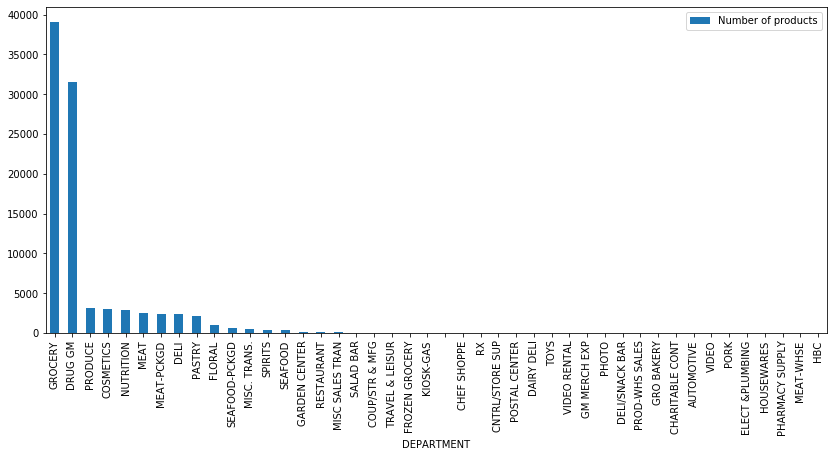

In [4]:
print('There are {0} unique products distributed in {1} different departments.'.format(len(products['PRODUCT_ID'].unique()), len(products['DEPARTMENT'].unique())))
products_per_dep = products.groupby("DEPARTMENT").count()["PRODUCT_ID"]\
                                   .sort_values(ascending=False).reset_index(name="Number of products")
products_per_dep.plot.bar(x="DEPARTMENT", y="Number of products",figsize=(14,6))

Every product corresponds to a row and there is no double products.
It is clearly seen that most of the products are in the GROCERY and DRUG GM Departments.
For this project, we will focus in food products. Therefore, a database with only food-related departments is created.

There are 56031 unique food products distributed in 18 different departments.


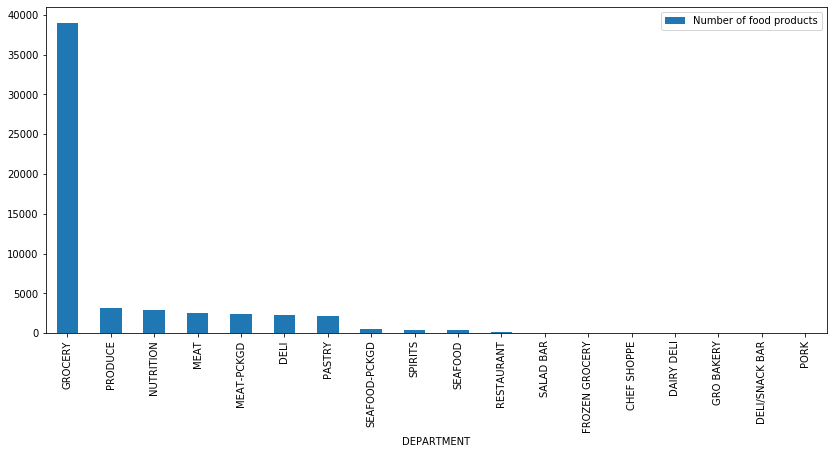

In [5]:
food_dep = ['GROCERY', 'PASTRY', 'MEAT-PCKGD','SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI',
       'MEAT', 'SEAFOOD', 'SALAD BAR', 'GRO BAKERY','FROZEN GROCERY', 'SPIRITS', 'RESTAURANT',
       'DAIRY DELI', 'CHEF SHOPPE', 'DELI/SNACK BAR', 'PORK']
food_products = products[products.DEPARTMENT.isin(food_dep)].copy()
print('There are {0} unique food products distributed in {1} different departments.'.format(len(food_products['PRODUCT_ID'].unique()), len(food_products['DEPARTMENT'].unique())))
food_products_per_dep = food_products.groupby("DEPARTMENT").count()["PRODUCT_ID"]\
                                   .sort_values(ascending=False).reset_index(name="Number of food products")
food_products_per_dep.plot.bar(x="DEPARTMENT", y="Number of food products",figsize=(14,6))

The GROCERY department contains nearly 70% of the products in the food sector. After a better look of the COMMODITY_DESC, some of them correspond to housecleaning and non-food commodities. 
Therefore, they have to be removed in the next step.

There are 51341 unique food products distributed in 18 different departments.


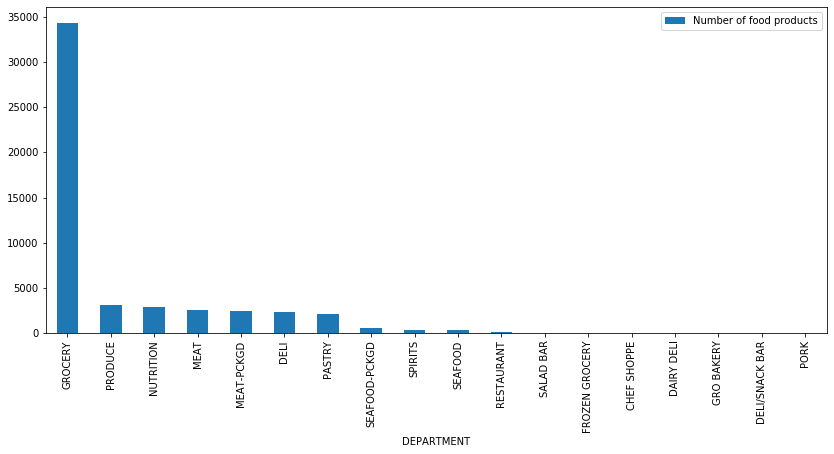

In [6]:
non_food_groceries = ['AIR CARE', 'PAPER HOUSEWARES', 'HOUSEHOLD CLEANG NEEDS', 'FD WRAPS/BAGS/TRSH BG', 'FACIAL TISS/DNR NAPKIN',\
                     'LAUNDRY DETERGENTS', 'LAUNDRY ADDITIVES', 'CAT FOOD', 'BATH TISSUES', 'DOG FOODS', 'BLEACH', 'PAPER TOWELS',\
                     'DISHWASH DETERGENTS', 'CAT LITTER', 'COUPON/MISC ITEMS', 'PET CARE SUPPLIES', 'BIRD SEED', 'BOTTLE DEPOSITS']
food_products = food_products[food_products['COMMODITY_DESC'].isin(non_food_groceries) == 0]
print('There are {0} unique food products distributed in {1} different departments.'.format(len(food_products['PRODUCT_ID'].unique()), len(food_products['DEPARTMENT'].unique())))
food_products_per_dep = food_products.groupby("DEPARTMENT").count()["PRODUCT_ID"]\
                                   .sort_values(ascending=False).reset_index(name="Number of food products")
food_products_per_dep.plot.bar(x="DEPARTMENT", y="Number of food products",figsize=(14,6))

This correction has allowed to remove nearly 5000 misplaced products.

## Scrape some websites to create a list of meat-related words

To find a maximum of meat related products, we have decided to refer to two different websites (https://www.listchallenges.com/types-of-meat and  https://www.manythings.org/vocabulary/lists/c/words.php) to get the words related to meat. These words are then used to select all the products whose DEPARTMENT, COMMODITY_DESC or SUB_COMMODITY_DESC contain one of these words.

In [7]:
meat_words = []

In [8]:
# First Website
urls = ["https://www.listchallenges.com/types-of-meat", "https://www.listchallenges.com/types-of-meat/list/2"]
for url in urls:
    r = get(url)
    page_body = r.text
    soup = BeautifulSoup(page_body, 'html.parser')
    meat_divs = soup.findAll("div", {"class": "item-name"})
    meat_words.extend([div.text.upper().strip() for div in meat_divs])
# Second Website   
base_url = "https://www.manythings.org/vocabulary/lists/c/words.php"
urls = [base_url + "?f=meat", base_url + "?f=fish"]
for url in urls:
    r = get(url)
    page_body = r.text
    soup = BeautifulSoup(page_body, 'html.parser')
    meat_li = soup.findAll("li")
    meat_words.extend([li.text.upper().strip() for li in meat_li])
    
# add particular words that are not in both websites
meat_words.extend(["SALAMI", "POULTRY", "SEAFOOD", "FISH","MEAT","MEATS"])

In [9]:
meat_words_regex = [r'\b%s\b' % word for word in meat_words]
full_regex = re.compile('|'.join(meat_words_regex))
meat_products = products[food_products.DEPARTMENT.str.contains(full_regex, regex=True)|\
                          food_products.COMMODITY_DESC.str.contains(full_regex, regex=True) |\
                          products.SUB_COMMODITY_DESC.str.contains(full_regex, regex=True)]
print('There are {0} meat products distributed in {1} different departments.'.format(len(meat_products['PRODUCT_ID'].unique()), len(meat_products['DEPARTMENT'].unique())))

There are 9035 meat products distributed in 9 different departments.


As for food products, some products are incorrectly placed in the meat category. They have to be removed by hand as before.

In [10]:
meat_drops_sub = [ 'FROZEN MEAT (VEGETARIAN)', 'VEGETARIAN MEATS', 'FRZN MEAT ALTERNATIVES', 'SAUERKRAUT', 'PICKLES',\
                  'SALADS', 'CHEESE', 'PICKLE ITEMS', 'SAL:OLIVES/PICKLES-BULK', 'POTATOES PROCESSED',\
                  'NON-MEATS - OTHER', 'MISC SALES TRANS', 'NON-MEATS - OTHER']
meat_products = meat_products[meat_products['SUB_COMMODITY_DESC'].isin(meat_drops_sub) == 0]
print('There are {0} meat products distributed in {1} different departments.'.format(len(meat_products['PRODUCT_ID'].unique()), len(meat_products['DEPARTMENT'].unique())))

There are 8783 meat products distributed in 9 different departments.


We can see that 17.6% of the food products are meat related products. In this part, we will make the distinction between two type of meat products. On one hand, we have all the products containing meat, a list we have just created. On other hand, we have meat and products that are mostly made of meat as sausages. The distinction must be made as the first contains all meat products but isn't exclusive while the second one only contains meat but does not contain it all.

In [11]:
drop_pure = [ 'DINNER MXS:DRY','PASTA SAUCE']
notpurewords = ["PIZZA", "SANDWICH","SANDWICHES","PASTA","CHILI", "STEW", "HASH","GRASS/SHRED","KITES","REGIONAL","ENTREES","BEANS",\
               "SAUCES","NOODLES","RICE","DAIRY","CONDIMENTS","SAUS","CHEESE","SPICES","BREADERS", "SAUCE", "HASHBROWN",\
               "SAUCESSALSAPICANTEE","MUSTARD"]
pure_meat = meat_products[meat_products['COMMODITY_DESC'].isin(drop_pure) == 0].copy()
notpure_regex = [r'\b%s\b' % word for word in notpurewords]
full_regex = re.compile('|'.join(notpure_regex))
pure_meat = pure_meat[pure_meat.SUB_COMMODITY_DESC.str.contains(full_regex, regex=True) == 0]
print('There are {0} pure meat products distributed in {1} different departments.'.format(len(pure_meat['PRODUCT_ID'].unique()), len(pure_meat['DEPARTMENT'].unique())))



There are 6607 pure meat products distributed in 9 different departments.


Text(0.5, 1.0, 'Pure meat products per Department')

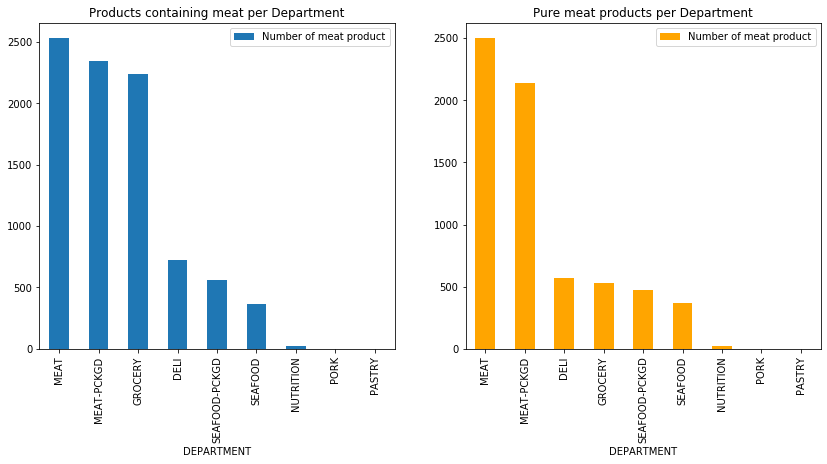

In [12]:

num_of_meat_per_dep = meat_products.groupby("DEPARTMENT").count()["PRODUCT_ID"]\
                                   .sort_values(ascending=False).reset_index(name="Number of meat product")
pure_meat_per_dep = pure_meat.groupby("DEPARTMENT").count()["PRODUCT_ID"]\
                                   .sort_values(ascending=False).reset_index(name="Number of meat product")

# plot histogram of normalized weights
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
num_of_meat_per_dep.plot.bar(x="DEPARTMENT", y="Number of meat product",ax=axes[0])
axes[0].set_title("Products containing meat per Department")

# plot histogram of not-normalized weights
pure_meat_per_dep.plot.bar(x="DEPARTMENT", y="Number of meat product",ax=axes[1], color='orange')
axes[1].set_title("Pure meat products per Department")

In the previous plot, it is clearly seen that most of the Departments contained mainly pure meat products. However, the Grocery department is the exception, where pure meat products only make up to a quarter of the total meat products. 

After all this part of data scrapping and selecting pure meat products, we want to know which is the meat's proportion for each meat category. There are 5 main categories : pork meat, poultry, bovine meat, ovine meat and seafood. 

In [13]:
pork_words = ['BACON', 'HAM','HAMS', 'PORK', 'SALAMI', 'LINKS', 'SAUSAGE']
bovine_words = ['BEEF', 'BUFFALO', 'VEAL']
ovine_words = ['GOAT', 'LAMB']
poultry_words = ['FOWL','THIGHS', 'DRUMS','CHICKEN','CHICK', 'CORNISH', 'DUCK', 'DUCKS', 'GOOSE', 'GROUSE', 'PHEASANT', 'TURKEY', 'POULTRY', 'HENS', 'BREAST','WINGS']
seafood_words = ['ANCHOVY', 'CATFISH', 'CLAMS', 'COD', 'CRAB', 'EEL', 'HALIBUT', 'LOBSTER', 'MACKEREL', 'MAHI MAHI', 'OCTOPUS', 'OYSTERS', 'QUAIL', 'SALMON', 'SARDINES', 'SCALLOPS', 'SHARK', 'SHRIMP', 'SQUAB', 'SQUID', 'SWORDFISH', 'TILAPIA', 'TUNA', 'SEAFOOD', 'FISH']
pork_regex = [r'\b%s\b' % word for word in pork_words]
full_pork_regex = re.compile('|'.join(pork_regex))
pork_products = pure_meat[pure_meat.SUB_COMMODITY_DESC.str.contains(full_pork_regex, regex=True) |\
                         pure_meat.COMMODITY_DESC.str.contains(full_pork_regex, regex=True) ]
bovine_regex = [r'\b%s\b' % word for word in bovine_words]
full_bovine_regex = re.compile('|'.join(bovine_regex))
bovine_products = pure_meat[pure_meat.SUB_COMMODITY_DESC.str.contains(full_bovine_regex, regex=True) |\
                         pure_meat.COMMODITY_DESC.str.contains(full_bovine_regex, regex=True)]
ovine_regex = [r'\b%s\b' % word for word in ovine_words]
full_ovine_regex = re.compile('|'.join(ovine_regex))
ovine_products = pure_meat[pure_meat.SUB_COMMODITY_DESC.str.contains(full_ovine_regex, regex=True)|\
                         pure_meat.COMMODITY_DESC.str.contains(full_ovine_regex, regex=True)]
poultry_regex = [r'\b%s\b' % word for word in poultry_words]
full_poultry_regex = re.compile('|'.join(poultry_regex))
poultry_products = pure_meat[pure_meat.SUB_COMMODITY_DESC.str.contains(full_poultry_regex, regex=True)|\
                         pure_meat.COMMODITY_DESC.str.contains(full_poultry_regex, regex=True)]
seafood_regex = [r'\b%s\b' % word for word in seafood_words]
full_seafood_regex = re.compile('|'.join(seafood_regex))
seafood_products = pure_meat[pure_meat.SUB_COMMODITY_DESC.str.contains(full_seafood_regex, regex=True)|\
                         pure_meat.COMMODITY_DESC.str.contains(full_seafood_regex, regex=True)]




In [14]:
other_meat = pure_meat[(pure_meat.PRODUCT_ID.isin(pork_products.PRODUCT_ID) | pure_meat.PRODUCT_ID.isin(bovine_products.PRODUCT_ID)|\
                      pure_meat.PRODUCT_ID.isin(ovine_products.PRODUCT_ID) | pure_meat.PRODUCT_ID.isin(poultry_products.PRODUCT_ID) |\
                      pure_meat.PRODUCT_ID.isin(seafood_products.PRODUCT_ID)) == 0]

In [15]:
pork_products = pork_products[pork_products.COMMODITY_DESC != "TURKEY"]
pork_products = pork_products[pork_products.SUB_COMMODITY_DESC != "SMOKED/COOKED - BEEF"]

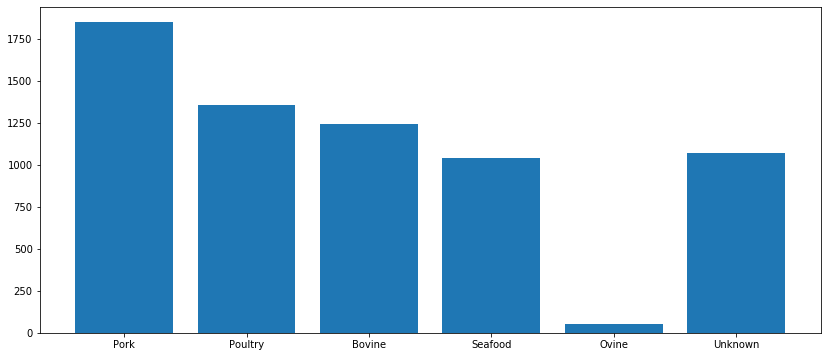

In [16]:
x = np.arange(6)
y = [len(pork_products), len(poultry_products), len(bovine_products),  len(seafood_products), len(ovine_products), len(other_meat)]
plt.figure(figsize=(14,6))
plt.bar(x, y)
plt.xticks(x, ( 'Pork', 'Poultry', 'Bovine','Seafood', 'Ovine', 'Unknown'))
plt.show()

We see that pork meat is the category with most products and that there are much less products in the ovine category than in the other categories. The "Unknown" category has the remaining products for which there is not enough information to classify in a category (e.g. sub-commodities with the words "burger" or "bbq").

## Get only vegetables

In [17]:
veggies = [
    "asparagus",
    "beans",
    "beet",
    "broccoli",
    "Brussels sprouts",
    "cabbage",
    "carrot",
    "carrots",
    "cauliflower",
    "celery",
    "Chinese cabbage",
    "corn",
    "cucumber",
    "cucumbers",
    "eggplant",
    "eggplants",
    "green pepper",
    "Japanese radish",
    "kale",
    "lettuce",
    "salad",
    "okra",
    "onion",
    "onions",
    "peas",
    "pumpkins",
    "radish",
    "spinach",
    "sweet potato",
    "tomatoes",
    "tomato",
    "turnips",
    "vegetables"
]
veggies = [v.upper() for v in veggies]

In [18]:
veggie_words_regex = [r'\b%s\b' % word for word in veggies]
full_regex = re.compile('|'.join(veggie_words_regex))

veggie_products = products[food_products.COMMODITY_DESC.str.contains(full_regex, regex=True) |\
                           products.SUB_COMMODITY_DESC.str.contains(full_regex, regex=True)]

In [19]:
drops_vegg = ['SHORTENING/OIL','CONDIMENTS/SAUCES', 'SALD DRSNG/SNDWCH SPRD', 'FROZEN MEAT','BAG SNACKS', 'BAKING MIXES',\
             'CRACKERS/MISC BKD FD', 'SPICES & EXTRACTS','BAKING NEEDS','MEAT - SHELF STABLE','DELI SPECIALTIES (RETAIL PK)', 'FROZEN PIZZA']
veggie_products = veggie_products[veggie_products['COMMODITY_DESC'].isin(drops_vegg) == 0]
print('There are {0} veggetables products distributed in {1} different departments.'.format(len(veggie_products['PRODUCT_ID'].unique()), len(veggie_products['DEPARTMENT'].unique())))


There are 3209 veggetables products distributed in 7 different departments.


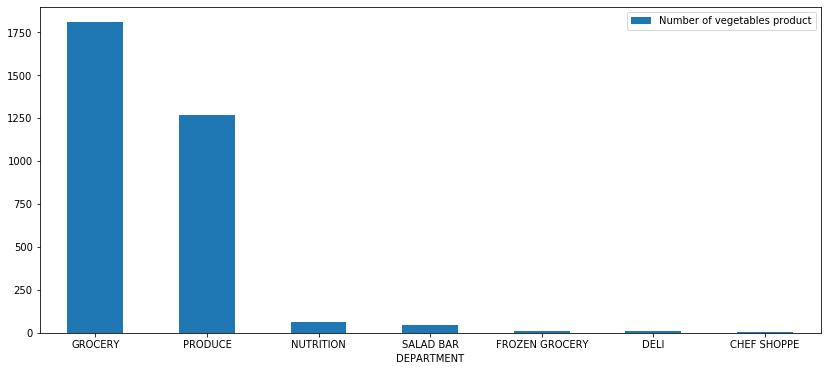

In [20]:
num_of_veg_per_dep = veggie_products.groupby("DEPARTMENT").count()["PRODUCT_ID"]\
                                   .sort_values(ascending=False).reset_index(name="Number of vegetables product")
num_of_veg_per_dep.plot.bar(x="DEPARTMENT", y="Number of vegetables product",figsize=(14,6), rot = 0)

It can be seen that most of the vegetable products are in the Grocery and Produce Department. Moreover, there are twice as much pure meat products than vegetable products.

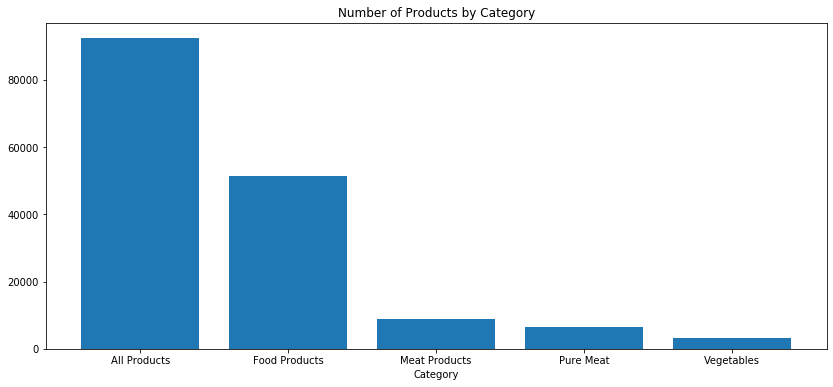

In [21]:
x = np.arange(5)
y = [len(products), len(food_products), len(meat_products),  len(pure_meat), len(veggie_products)]

plt.figure(figsize=(14,6))
plt.bar( x, y)
plt.xticks(x, ( 'All Products', 'Food Products', 'Meat Products','Pure Meat', 'Vegetables'))
plt.xlabel("Category")
plt.title("Number of Products by Category")
plt.show()

Load data to csv files to be used on the main part.

In [22]:
products.to_csv('data/products.csv')
food_products.to_csv('data/food_products.csv')
meat_products.to_csv('data/meat_products.csv')
pure_meat.to_csv('data/pure_meat.csv')
veggie_products.to_csv('data/vegetables_products.csv')
